In [15]:
####导入相关包####
from pandas import read_csv
from datetime import datetime
import pandas as pd

In [2]:
####数据加载，将原始数据格式中的year, month, day, hour进行合并####
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
print(dataset.head())
dataset.drop('No', axis=1, inplace=True)

                     No  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
year_month_day_hour                                                   
2010-01-01 00:00:00   1    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2010-01-01 01:00:00   2    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2010-01-01 02:00:00   3    NaN   -21 -11.0  1019.0   NW   6.71   0   0
2010-01-01 03:00:00   4    NaN   -21 -14.0  1019.0   NW   9.84   0   0
2010-01-01 04:00:00   5    NaN   -20 -12.0  1018.0   NW  12.97   0   0


In [3]:
# 列名替换
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [4]:
# 缺失值填充
dataset['pollution'].fillna(0, inplace=True)
# 去掉第一天数据（前24小时）
dataset = dataset[24:]
# 数据浏览
print(dataset.head(5))
# 数据保存
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [9]:
dataset
dataset.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')

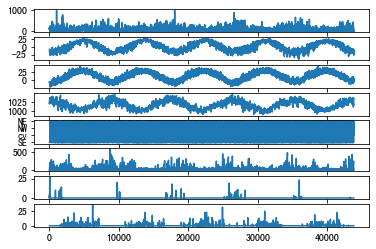

In [6]:
####eda 过程####
values=dataset.values
import matplotlib.pyplot as plt
# groups=[0,1,2,3,4,5,6,7]
i=1
for group in range(8):
    plt.subplot(8,1,i)
    plt.plot(values[:,group])
    plt.title=dataset.columns[group]
    i=i+1
plt.show()

In [8]:
####将分类特征进行encoder####
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
values[:,4]=encoder.fit_transform(values[:,4])
values=values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [11]:
####数据规范化####
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled=scaler.fit_transform(values)
scaled.shape

(43800, 8)

In [13]:
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [16]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.to_csv('reframed-1.csv')
# 去掉不需要预测的列，即var2(t) var3(t) var4(t) var5(t) var6(t) var7(t) var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv('reframed-2.csv')
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [18]:
####数据集划分
values=reframed.values
n_train_hours=int(len(values)*0.8)
train=values[:n_train_hours,:]
test=values[n_train_hours:,:]
train_x,train_y=train[:,:-1],train[:,-1]
test_x,test_y=test[:,:-1],test[:,-1]
train_x.shape

(35039, 8)

In [19]:
####转换为3D格式 [样本数 时间步 特征数 ]
train_x=train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x=test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [24]:
###设置网络模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
result=model.fit(train_x, train_y, epochs=10, batch_size=64, validation_data=(test_x,test_y),verbose=2, shuffle=False)

Epoch 1/10
548/548 - 9s - loss: 0.0026 - val_loss: 0.0087
Epoch 2/10
548/548 - 7s - loss: 9.0588e-04 - val_loss: 0.0033
Epoch 3/10
548/548 - 8s - loss: 8.1483e-04 - val_loss: 0.0020
Epoch 4/10
548/548 - 10s - loss: 8.0159e-04 - val_loss: 0.0016
Epoch 5/10
548/548 - 10s - loss: 8.0029e-04 - val_loss: 0.0014
Epoch 6/10
548/548 - 10s - loss: 8.0091e-04 - val_loss: 0.0012
Epoch 7/10
548/548 - 9s - loss: 8.0179e-04 - val_loss: 0.0012
Epoch 8/10
548/548 - 8s - loss: 8.0202e-04 - val_loss: 0.0011
Epoch 9/10
548/548 - 10s - loss: 8.0175e-04 - val_loss: 0.0011
Epoch 10/10
548/548 - 11s - loss: 8.0122e-04 - val_loss: 0.0011


In [ ]:
####model predict####
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

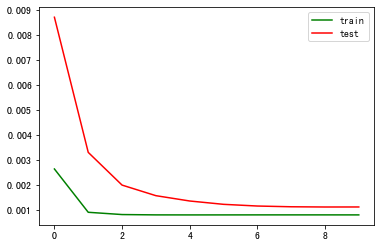

In [25]:
####train test plot####
line1=result.history['loss']
line2=result.history['val_loss']
plt.plot(line1,label='train',c='g')
plt.plot(line2,label='test',c='r')
plt.legend(loc='best')
plt.show()

In [26]:
#### model summary####
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
